In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_216.mp4
/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_98.mp4
/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_137.mp4
/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_86_1.mp4
/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_19_1.mp4
/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_202.mp4
/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_159.mp4
/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_217.mp4
/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_185_1.mp4
/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_40_1.mp4
/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_107.mp4
/kaggle/input/Shop DataSet/non shop lifters/videppppsss_37.mp4
/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_218_1.mp4
/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_140_1.mp4
/kaggle/input/Shop DataSet/non shop lifters/shop_lifter_n_32_1.mp4
/kag

In [2]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)


/kaggle/input
/kaggle/input/Shop DataSet
/kaggle/input/Shop DataSet/non shop lifters
/kaggle/input/Shop DataSet/shop lifters


In [11]:
import os
import pandas as pd


In [3]:
base_dir = "/kaggle/input/Shop DataSet"

shoplifters_dir = os.path.join(base_dir, "shop lifters")
nonshoplifters_dir = os.path.join(base_dir, "non shop lifters")

print("Shoplifters folder exists:", os.path.exists(shoplifters_dir))
print("Non-shoplifters folder exists:", os.path.exists(nonshoplifters_dir))


Shoplifters folder exists: True
Non-shoplifters folder exists: True


In [4]:
shop_videos = [os.path.join(shoplifters_dir, f) for f in os.listdir(shoplifters_dir)]
nonshop_videos = [os.path.join(nonshoplifters_dir, f) for f in os.listdir(nonshoplifters_dir)]

print(f"Shoplifters videos: {len(shop_videos)}")
print(f"Non-shoplifters videos: {len(nonshop_videos)}")


Shoplifters videos: 324
Non-shoplifters videos: 531


In [5]:
df = pd.DataFrame({
    "path": shop_videos + nonshop_videos,
    "label": [1] * len(shop_videos) + [0] * len(nonshop_videos)
})

print(" DataFrame created successfully!")
print("Shape:", df.shape)
df.head()


 DataFrame created successfully!
Shape: (855, 2)


,path,label
0,/kaggle/input/Shop DataSet/shop lifters/shop_l...,1
1,/kaggle/input/Shop DataSet/shop lifters/videyy...,1
2,/kaggle/input/Shop DataSet/shop lifters/shop_l...,1
3,/kaggle/input/Shop DataSet/shop lifters/videyy...,1
4,/kaggle/input/Shop DataSet/shop lifters/videpp...,1


In [6]:
min_count = df["label"].value_counts().min()

df_balanced = pd.concat([
    df[df["label"] == 1].sample(min_count, random_state=42),
    df[df["label"] == 0].sample(min_count, random_state=42)
])

print(" Balanced dataset size:", len(df_balanced))
df_balanced.head()


 Balanced dataset size: 648


,path,label
132,/kaggle/input/Shop DataSet/shop lifters/videyy...,1
108,/kaggle/input/Shop DataSet/shop lifters/videyy...,1
137,/kaggle/input/Shop DataSet/shop lifters/videpp...,1
9,/kaggle/input/Shop DataSet/shop lifters/videpp...,1
180,/kaggle/input/Shop DataSet/shop lifters/shop_l...,1


In [7]:
output_path = "/kaggle/working/labels_balanced.csv"
df_balanced.to_csv(output_path, index=False)

print(" Saved balanced dataset to:", output_path)


 Saved balanced dataset to: /kaggle/working/labels_balanced.csv


In [8]:
df_check = pd.read_csv(output_path)
print(" Reloaded balanced CSV successfully!")
print("Shape:", df_check.shape)
df_check.head()


 Reloaded balanced CSV successfully!
Shape: (648, 2)


,path,label
0,/kaggle/input/Shop DataSet/shop lifters/videyy...,1
1,/kaggle/input/Shop DataSet/shop lifters/videyy...,1
2,/kaggle/input/Shop DataSet/shop lifters/videpp...,1
3,/kaggle/input/Shop DataSet/shop lifters/videpp...,1
4,/kaggle/input/Shop DataSet/shop lifters/shop_l...,1


In [ ]:
# Kaggle usually has many packages installed, but we ensure needed ones.
# This cell runs shell commands; run as a code cell.
!pip install -q transformers[torch] timm einops accelerate datasets scikit-learn matplotlib seaborn opencv-python albumentations


In [9]:
# Imports and environment check
import os, sys, random, math, glob, time, json, tempfile
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report

print("Python:", sys.version)
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available(), "Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Torch: 2.6.0+cu124
CUDA available: True Device: Tesla T4


In [10]:
# Adjust this to your dataset base path
BASE_DIR = Path("/kaggle/input/Shop DataSet")
shop_dir = BASE_DIR / "shop lifters"
nonshop_dir = BASE_DIR / "non shop lifters"

assert shop_dir.exists() and nonshop_dir.exists(), "Dataset folders missing; check BASE_DIR"

shop_videos = sorted(list(map(str, shop_dir.glob("*"))))
nonshop_videos = sorted(list(map(str, nonshop_dir.glob("*"))))

print("Found shop lifter videos:", len(shop_videos))
print("Found non-shoplifters videos:", len(nonshop_videos))


Found shop lifter videos: 324
Found non-shoplifters videos: 531


In [11]:
# Create CSV with paths and labels (1 = shoplifter, 0 = non)
df = pd.DataFrame({
    "path": shop_videos + nonshop_videos,
    "label": [1]*len(shop_videos) + [0]*len(nonshop_videos)
})

# Balance by under-sampling the majority class
min_count = df['label'].value_counts().min()
df_bal = pd.concat([
    df[df['label']==1].sample(min_count, random_state=42),
    df[df['label']==0].sample(min_count, random_state=42)
]).reset_index(drop=True)

df_bal.to_csv("/kaggle/working/labels_balanced.csv", index=False)
print("Balanced dataset saved to /kaggle/working/labels_balanced.csv; shape:", df_bal.shape)
df_bal.head()


Balanced dataset saved to /kaggle/working/labels_balanced.csv; shape: (648, 2)


,path,label
0,/kaggle/input/Shop DataSet/shop lifters/videmm...,1
1,/kaggle/input/Shop DataSet/shop lifters/shop_l...,1
2,/kaggle/input/Shop DataSet/shop lifters/videmm...,1
3,/kaggle/input/Shop DataSet/shop lifters/shop_l...,1
4,/kaggle/input/Shop DataSet/shop lifters/videpp...,1


In [12]:
# PARAMETERS - tune these for memory / speed
NUM_FRAMES = 16         # frames per clip (temporal length)
IMAGE_SIZE = 224        # spatial resize (H and W)
CACHE_DIR = Path("/kaggle/working/frame_cache")
CACHE_DIR.mkdir(exist_ok=True, parents=True)

def sample_frame_indices(num_frames, total_frames):
    if total_frames <= 0:
        return np.zeros(num_frames, dtype=int)
    return np.linspace(0, max(total_frames-1,0), num_frames, dtype=int)

def extract_and_cache(video_path, cache_path, num_frames=NUM_FRAMES, image_size=IMAGE_SIZE):
    cache_path = Path(cache_path)
    if cache_path.exists():
        return True
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print("Failed to open:", video_path)
        return False
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = sample_frame_indices(num_frames, total)
    frames = []
    last_frame = None
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(i))
        ret, frame = cap.read()
        if not ret:
            if last_frame is None:
                # create black frame
                frame = np.zeros((image_size, image_size, 3), dtype=np.uint8)
            else:
                frame = last_frame
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (image_size, image_size))
        last_frame = frame
        frames.append(frame)
    cap.release()
    arr = np.stack(frames)  # T,H,W,C
    np.save(cache_path, arr, allow_pickle=False)
    return True

# Create a mapping CSV with cache paths
balanced_csv = "/kaggle/working/labels_balanced.csv"
df = pd.read_csv(balanced_csv)
df['cache_path'] = df['path'].apply(lambda p: str(CACHE_DIR / (Path(p).stem + ".npy")))

# Extract in loop with progress bar (skip existing caches)
print("Starting frame extraction — this may take several minutes depending on dataset size.")
for i,row in tqdm(df.iterrows(), total=len(df)):
    p = row['path']
    c = row['cache_path']
    if not Path(c).exists():
        ok = extract_and_cache(p, c)
        if not ok:
            print("Failed:", p)
print("Frame extraction complete. Cached frames:", len(list(CACHE_DIR.glob("*.npy"))))


Starting frame extraction — this may take several minutes depending on dataset size.


  0%|          | 0/648 [00:00<?, ?it/s]

Frame extraction complete. Cached frames: 617


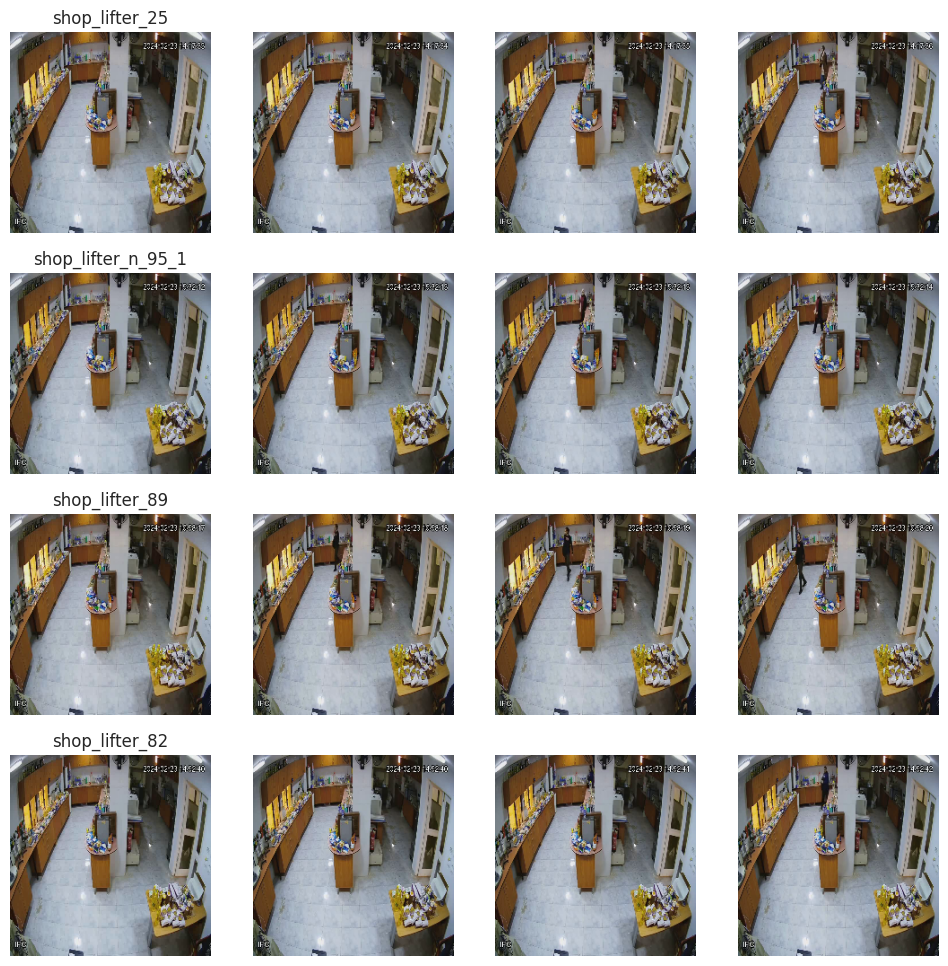

In [13]:
# Pick few cached samples and plot first/few frames
sample = list(CACHE_DIR.glob("*.npy"))[:4]
fig, axes = plt.subplots(len(sample), 4, figsize=(12,3*len(sample)))
for i, p in enumerate(sample):
    arr = np.load(p)  # T,H,W,C
    for j in range(4):
        ax = axes[i,j] if len(sample)>1 else axes[j]
        ax.imshow(arr[j])
        ax.axis('off')
        if j==0:
            ax.set_title(Path(p).stem)
plt.show()


In [ ]:
# ==========================================
# CELL 9 — SUPER-STABLE DATASET FOR VIDEOMAE
# ==========================================

class VideoNpyDataset(Dataset):
    def __init__(self, df, num_frames=NUM_FRAMES, mode='train'):
        self.df = df.reset_index(drop=True)
        self.num_frames = num_frames
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.loc[idx]
        arr = np.load(row["cache_path"])   # (T, H, W, C)

        # always convert to float and keep 3 channels
        arr = arr.astype(np.float32) / 255.0

        # sample frames
        T = arr.shape[0]
        if T != self.num_frames:
            idxs = np.linspace(0, T-1, self.num_frames, dtype=int)
            arr = arr[idxs]

        # ensure correct ordering (T, H, W, C)
        if arr.shape[-1] != 3:
            # fix grayscale or weird channel flips
            arr = np.repeat(arr[..., :1], 3, axis=-1)

        # convert to (T, C, H, W)
        arr = np.transpose(arr, (0, 3, 1, 2))  # T,3,H,W

        # convert to pytorch tensor -> model will get (B,T,3,H,W)
        frames = torch.tensor(arr, dtype=torch.float32)

        return frames, torch.tensor(row["label"], dtype=torch.long)


In [ ]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
import torch
from torch.utils.data import DataLoader


In [ ]:
!pip uninstall -y transformers tokenizers accelerate bitsandbytes


In [2]:
!pip install transformers==4.33.2 --quiet


In [3]:
import transformers
print(transformers.__version__)


4.33.2


In [14]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Transformers version:", __import__("transformers").__version__)


2025-11-21 04:31:24.079525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763699484.270671      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763699484.327885      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Transformers version: 4.53.3


In [15]:
BASE_DIR = "/kaggle/input/Shop DataSet"
SHOP_DIR = os.path.join(BASE_DIR, "shop lifters")
NONSHOP_DIR = os.path.join(BASE_DIR, "non shop lifters")

shop_files = [os.path.join(SHOP_DIR, f) for f in os.listdir(SHOP_DIR) if f.endswith((".mp4", ".avi"))]
nonshop_files = [os.path.join(NONSHOP_DIR, f) for f in os.listdir(NONSHOP_DIR) if f.endswith((".mp4", ".avi"))]

df = pd.DataFrame({
    "path": shop_files + nonshop_files,
    "label": [1]*len(shop_files) + [0]*len(nonshop_files)
})
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

train_csv = "/kaggle/working/train.csv"
val_csv = "/kaggle/working/val.csv"
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)
print("Train:", len(train_df), "Val:", len(val_df))


Train: 684 Val: 171


In [18]:
class VideoMAEDataset(Dataset):
    def __init__(self, df, processor, num_frames=16, max_len=16):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.num_frames = num_frames
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def _read_video_frames(self, path, num_frames):
        cap = cv2.VideoCapture(path)
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total <= 0:
            raise RuntimeError(f"Empty video: {path}")
        idxs = np.linspace(0, total - 1, num_frames).astype(int)
        frames = []
        for i in range(total):
            ret, frame = cap.read()
            if not ret:
                break
            if i in idxs:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
        cap.release()
        return frames

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = row["path"]
        label = int(row["label"])
        frames = self._read_video_frames(video_path, self.num_frames)
        processed = self.processor(frames, return_tensors="pt")
        pixel_values = processed["pixel_values"].squeeze(0)  # (num_frames, 3, H, W)
        return {"pixel_values": pixel_values, "labels": torch.tensor(label)}


In [19]:
model_name = "MCG-NJU/videomae-base"
processor = VideoMAEImageProcessor.from_pretrained(model_name)
model = VideoMAEForVideoClassification.from_pretrained(model_name, num_labels=2)
model.to(DEVICE)

train_dataset = VideoMAEDataset(train_df, processor, num_frames=16)
val_dataset   = VideoMAEDataset(val_df, processor, num_frames=16)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/377M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
epochs = 3
best_val_acc = 0.0
save_path = "/kaggle/working/videomae_best.pth"

for epoch in range(1, epochs+1):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in tqdm(train_loader):
        pixel_values = batch["pixel_values"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        outputs = model(pixel_values, labels=labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    train_loss = total_loss / total

    # Validation
    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            outputs = model(pixel_values, labels=labels)
            val_loss += outputs.loss.item() * labels.size(0)
            preds = outputs.logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    print(f"Epoch {epoch}: Train loss={train_loss:.4f} acc={train_acc:.4f} | Val loss={val_loss:.4f} acc={val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print("✅ Saved best model:", save_path)
 

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 1: Train loss=0.4279 acc=0.7953 | Val loss=0.0942 acc=0.9649
✅ Saved best model: /kaggle/working/videomae_best.pth


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 2: Train loss=0.0697 acc=0.9708 | Val loss=0.0048 acc=1.0000
✅ Saved best model: /kaggle/working/videomae_best.pth


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 3: Train loss=0.0024 acc=1.0000 | Val loss=0.0015 acc=1.0000


In [21]:
def predict_video(video_path):
    model.eval()
    frames = VideoMAEDataset(train_df, processor)._read_video_frames(video_path, 16)
    inputs = processor(frames, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    pred = int(np.argmax(probs))
    return {"prob_nonshop": float(probs[0]), "prob_shop": float(probs[1]), "pred": pred}


In [22]:
import gradio as gr

In [ ]:
!pip install fpdf

In [ ]:
# ==========================
# FINAL WORKING GRADIO APP
# ==========================

import gradio as gr
import cv2, numpy as np, torch, time, io
from PIL import Image
import matplotlib.pyplot as plt

# Load model
model.load_state_dict(torch.load(save_path, map_location=DEVICE))
model.eval()

NUM_FRAMES = 16
STRIDE = 8
TOP_K = 4

# --- Utility Functions ---

def extract_all_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    return frames

def frames_to_batch(frames_subset):
    # Process frames using your VideoMAE processor
    pv = processor(frames_subset, return_tensors="pt")["pixel_values"]
    return pv.to(DEVICE)

def predict_sliding(frames):
    T = len(frames)
    if T < NUM_FRAMES:
        frames = frames + [frames[-1]]*(NUM_FRAMES-T)
        T = len(frames)

    probs = []
    centers = []
    windows = []

    for start in range(0, T-NUM_FRAMES+1, STRIDE):
        subset = frames[start:start+NUM_FRAMES]
        batch = frames_to_batch(subset)

        with torch.no_grad():
            out = model(pixel_values=batch)
            p = torch.softmax(out.logits, dim=1)[0,1].item()

        probs.append(p)
        centers.append(start + NUM_FRAMES//2)
        windows.append((start, start+NUM_FRAMES))

    return centers, probs, windows

def plot_timeline(probs, centers):
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(centers, probs, marker="o")
    ax.set_ylim(0,1)
    ax.set_title("Shoplifting Probability Timeline")
    ax.set_xlabel("Frame Index")
    ax.set_ylabel("Probability")
    ax.grid(alpha=0.3)

    buf = io.BytesIO()
    fig.savefig(buf, format="png")
    plt.close(fig)
    buf.seek(0)

    return np.array(Image.open(buf))

def top_k_frames(frames, probs, windows):
    if len(probs)==0:
        return []

    idxs = np.argsort(probs)[::-1][:TOP_K]
    outputs = []

    for i in idxs:
        s, e = windows[i]
        center = (s+e)//2
        img = frames[center]
        desc = f"Frame {center} | Prob={probs[i]:.2f}"
        outputs.append((img, desc))

    return outputs

# ---------------------------
# GRADIO PREDICT FUNCTION
# ---------------------------

def gradio_predict(video):
    # Fix: normalize video path
    try:
        video_path = video if isinstance(video, str) else video.name
    except:
        video_path = video["name"] if isinstance(video, dict) else video

    frames = extract_all_frames(video_path)
    if len(frames)==0:
        return "Error reading video", None, None

    centers, probs, windows = predict_sliding(frames)

    if len(probs)==0:
        return "Video too short or unreadable", None, None

    final_prob = float(np.max(probs))
    label = "🔴 SHOPLIFTING" if final_prob>=0.5 else "🟢 NORMAL"

    timeline_img = plot_timeline(probs, centers)
    topk = top_k_frames(frames, probs, windows)

    # Return summary, timeline numpy, gallery list
    gallery_imgs = [(img, desc) for img, desc in topk]

    return f"{label}  | Probability={final_prob:.3f}", timeline_img, gallery_imgs

# ---------------------------
# GRADIO USER INTERFACE
# ---------------------------

with gr.Blocks() as demo:
    gr.Markdown("# 🎥 Shoplifting Detection — Demo")

    with gr.Row():
        with gr.Column(scale=1):
            video_input = gr.Video(label="Upload CCTV Footage")
            run_btn = gr.Button("Analyze")
            result_text = gr.Textbox(label="Prediction Result", lines=2)

        with gr.Column(scale=1):
            timeline_out = gr.Image(label="Probability Timeline")
            gallery_out = gr.Gallery(
                label="Top Risky Frames",
                columns=2,
                rows=2
            )

    run_btn.click(
        fn=gradio_predict,
        inputs=video_input,
        outputs=[result_text, timeline_out, gallery_out]
    )

demo.launch(debug=True)


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://9a305e13e60f15329b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
